In [14]:
import pandas as pd
import json
import os
import re

os.chdir("..")

### BASIL

In [ ]:
folder_path = "../data/raw/basil"

all_rows = []

source_mapping = {"fox": "fox-news",
                  "nyt": "the-new-york-times",
                  "hpo": "huffpost"}

# Loop through each JSON file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".json"):
        file_path = os.path.join(folder_path, filename)
        
        # Load JSON data
        with open(file_path, 'r') as file:
            data = json.load(file)
        

        for entry in data.get("body", []):
            sentence = entry.get("sentence", "")
            
            # Check if any annotation in the sentence has lexical bias
            has_lexical_bias = any(annotation.get("bias") == "Lexical" for annotation in entry.get("annotations", []))

            source = data.get("source", "").lower()
            source = source_mapping.get(source, source)
            
            row = {
                "text": sentence,
                "date": data.get("date", ""),
                "source": source,
                "article_main_entities": ", ".join(data.get("main-entities", [])),
                "label": int(has_lexical_bias)  # 1 if lexical bias exists, otherwise 0
            }
            
            all_rows.append(row)

df = pd.DataFrame(all_rows)

In [ ]:
df.groupby("source")["label"].value_counts()

#its very sparse!

source              label
fox-news            0        2498
                    1         141
huffpost            0        2147
                    1         149
the-new-york-times  0        2891
                    1         158
Name: count, dtype: int64

### ANNOMATIC

In [22]:
ad_fontes = pd.read_csv("../data/adfontes_clean.csv")

ad_fontes["source"].unique().tolist()

annomatic =  pd.read_parquet("../data/raw/anno-lexical-train.parquet")
annomatic = annomatic.merge(ad_fontes, left_on= 'source_name', right_on= "source", how= 'left')

In [25]:
annomatic[annomatic["source"].isna()]["source_name"].unique()

array(['san-diego-uniontribune', 'atlanta-journalconstitution', 'nj',
       'insider', 'chicago-suntimes', 'the-advocate',
       'pittsburgh-postgazette'], dtype=object)

In [28]:
source_mapping = {
    "the-advocate": "the-advocate-–-baton-rouge",
    "atlanta-journalconstitution": "atlanta-journal-constitution",
    "chicago-suntimes": "chicago-sun-times",
    "san-diego-uniontribune": "san-diego-union-tribune",
    "pittsburgh-postgazette": "pittsburgh-post-gazette",
    "nj": "nj.com",
    "insider": "business-insider"
}


annomatic =  pd.read_parquet("../data/raw/anno-lexical-train.parquet")
annomatic["source_name"] = annomatic["source_name"].replace(source_mapping)

annomatic = annomatic.merge(ad_fontes, left_on = 'source_name', right_on= 'source', how= 'left')
annomatic = annomatic.drop(columns=['source_name'])
annomatic

,text,source_party,label,sentence_id,source,reliability,bias
0,"General Admission: $25, $20 for seniors and mi...",Lean Left,0,31bef2d8-f7e5-42ce-a278-ae201dd3e1fe,san-diego-union-tribune,45.68,-1.76
1,Proceeds benefit children and adults with disa...,Lean Left,0,412c7cde-e3b4-46c5-b91d-c0b7b1d813e1,san-diego-union-tribune,45.68,-1.76
2,One day before he is set to surrender to autho...,Left,1,6e2d7083-52da-4072-989b-ca42e5d69679,alternet,32.71,-14.76
3,"In America, Paul snapped a picture of newsmen ...",Lean Right,0,b93dacc5-9fe1-4da9-aa18-32271b836feb,boston-herald,36.31,9.68
4,None of the diarists of ages and administratio...,Lean Left,1,1f161884-32a0-4f7d-824e-907826b1669b,the-guardian,40.67,-7.97
...,...,...,...,...,...,...,...
33826,"When lawsuits started piling up, the Sacklers ...",Lean Left,1,04eae3d6-da64-474f-876e-5c12d79586f5,the-economist,42.40,-1.43
33827,As almost always is the case when Republicans ...,Lean Right,1,a2849664-4a15-4458-a07d-32349cb16572,the-dispatch,41.19,5.33
33828,DeSantis has taken an aggressive - and controv...,Lean Left,1,107d49a1-6b7e-4619-81dc-e881ff30fd79,nbc-news,43.21,-5.79
33829,It is one of the most significant investigativ...,Center,0,804d894d-f0c4-4600-856a-c0761a0e9947,poynter,41.75,-7.32


### Starbucks 

A lot of media missing from all sides/adfontes

In [27]:

#?rare guns the sun rte tekegraph recode dallas-news bbc-news digital-journal deccan-herald, tasnim-news-agency-(press-release) the-national-memo-(blog) valuewalk

source_mapping = {
    'nbcnews': 'nbc-news',
    'time': 'time-magazine',
    'sputnik-international': 'sputnik-international-news',
    'new-york-times': 'the-new-york-times',
    'the-hill': 'hill-reporter',
    'breitbart-news': 'breitbart',
    'american-thinker-(blog)': 'american-thinker',
    'dallas-news': 'dallas-morning-news',
    'bbc-news': 'bbc'
}

folder_path = "../data/raw"
starbucks = pd.read_csv(os.path.join(folder_path,"Sora_LREC2020_biasedsentences.csv"))

starbucks['source'] = starbucks['source'].apply(lambda x: '-'.join(re.sub(r'_\d+', '', x.split('_', 1)[1]).lower().split()))
starbucks['source'] = starbucks['source'].replace(source_mapping)

starbucks = starbucks.merge(ad_fontes, on= 'source', how= 'left')

In [30]:
row_list = []
for _, df in starbucks.groupby("id_article"):
    # Extract values that are the same across the group (first row of the group)
    source = df['source'].iloc[0]
    reliability = df['reliability'].iloc[0]
    bias = df['bias'].iloc[0]
    source_bias = df['source_bias'].iloc[0]
    date = df['date_event'].iloc[0]

    # Add title entry
    row_list.append({
        "text": df["doctitle"].iloc[0],
        "label": df["t"].mean(),
        "source": source,
        "reliability": reliability,
        "bias": bias,
        "source_bias": source_bias,
        "date": date
    })

    # Add sentence entries
    for sent in range(20):
        # Check if sentence exists in the article (it might be missing)
        if not df["s" + str(sent)].any():
            continue

        sentence = df["s" + str(sent)].iloc[0]  # sentences are the same within the group, take the first one
        label = df[str(sent)].mean()  # we take the mean of annotations for the sentence

        # Append sentence information with additional columns
        row_list.append({
            "text": sentence,
            "source": source,
            "label": label,
            "reliability": reliability,
            "bias": bias,
            "source_bias": source_bias,
            "date": date
        })

# Convert the row list to a DataFrame
data = pd.DataFrame(row_list)

data["text"] = data["text"].apply(lambda x: re.sub(r"(\[[0-9]*\]:\ )", "", x))
data["label"] = (data["label"] - data["label"].min()) / (data["label"].max() - data["label"].min())

data

,text,label,source,reliability,bias,source_bias,date
0,Dan Johnson suicide: Lawmaker accused of moles...,0.727273,washington-post,38.8,-6.85,left-center,2017-12-15
1,LOUISVILLE - Dan Johnson posted a final messag...,0.363636,washington-post,38.8,-6.85,left-center,2017-12-15
2,It appeared to be a goodbye.,0.727273,washington-post,38.8,-6.85,left-center,2017-12-15
3,"In it, he denied the accusations that had torm...",0.545455,washington-post,38.8,-6.85,left-center,2017-12-15
4,"""GOD knows the truth, nothing is the way they ...",0.363636,washington-post,38.8,-6.85,left-center,2017-12-15
...,...,...,...,...,...,...,...
883,But I'm also confident that Secretary Mattis w...,0.363636,valuewalk,NaN,NaN,right-center,2017-12-13
884,Tillerson also emphasized his partnership with...,0.145455,valuewalk,NaN,NaN,right-center,2017-12-13
885,The change in position comes on the heels of P...,0.072727,valuewalk,NaN,NaN,right-center,2017-12-13
886,The Hwasong-15 missile that was launched Novem...,0.290909,valuewalk,NaN,NaN,right-center,2017-12-13


### BABE

In [35]:
source_mapping = {
    "federalist": "the-federalist",
    "new-york-times": "the-new-york-times",
}
# the-daily-stormer is missing
bias_mapping = {"Biased" : 1, "Non-biased": 0}

df = pd.read_csv("../data/raw/babe.csv", delimiter= ";")
df["outlet"] = df["outlet"].str.lower().str.replace(" ", "-")
df["outlet"] = df["outlet"].replace(source_mapping)

df["label_bias"] = df["label_bias"].map(bias_mapping)

df = df.merge(ad_fontes, left_on = 'outlet', right_on= 'source', how= 'left')

df.head()

,text,news_link,outlet,topic,type,label_bias,label_opinion,biased_words,source,reliability,bias
0,"""Orange Is the New Black"" star Yael Stone is r...",https://www.foxnews.com/entertainment/australi...,fox-news,environment,right,0.0,Entirely factual,[],fox-news,35.44,11.06
1,"""We have one beautiful law,"" Trump recently sa...",https://www.alternet.org/2020/06/law-and-order...,alternet,gun control,left,1.0,Somewhat factual but also opinionated,"['bizarre', 'characteristically']",alternet,32.71,-14.76
2,"...immigrants as criminals and eugenics, all o...",https://www.nbcnews.com/news/latino/after-step...,msnbc,white-nationalism,left,1.0,Expresses writer’s opinion,"['criminals', 'fringe', 'extreme']",msnbc,34.51,-14.03
3,...we sounded the alarm in the early months of...,https://www.alternet.org/2019/07/fox-news-has-...,alternet,white-nationalism,left,1.0,Somewhat factual but also opinionated,[],alternet,32.71,-14.76
4,[Black Lives Matter] is essentially a non-fals...,http://feedproxy.google.com/~r/breitbart/~3/-v...,breitbart,marriage-equality,NaN,1.0,Expresses writer’s opinion,['cult'],breitbart,31.15,13.70


In [33]:
df[df["label_bias"].isna()]

,text,news_link,outlet,topic,type,label_bias,label_opinion,biased_words,source,reliability,bias
2143,Proponents of these vaccines twist the Vatican...,https://thefederalist.com/2020/05/06/as-long-a...,the-federalist,vaccines,right,NaN,Expresses writer’s opinion,[],the-federalist,21.77,18.67


In [36]:
df[df['label_opinion'] == "No agreement"]

,text,news_link,outlet,topic,type,label_bias,label_opinion,biased_words,source,reliability,bias
41,"A cop shoots a Black man, and a police union f...",https://www.reuters.com/investigates/special-r...,reuters,gun control,center,1.0,No agreement,"['flexes', 'its', 'muscle']",reuters,45.18,-1.17
94,A previous boom that saw gun sales double over...,https://www.reuters.com/article/us-usa-guns-sa...,reuters,gun-control,center,1.0,No agreement,['aficionados'],reuters,45.18,-1.17
95,A professor who teaches climate change classes...,https://www.breitbart.com/politics/2019/05/09/...,breitbart,environment,right,0.0,No agreement,[],breitbart,31.15,13.70
121,A Supreme Court filing lays bare the deep chas...,https://www.alternet.org/2020/03/prominent-rep...,alternet,taxes,left,1.0,No agreement,['wannabe'],alternet,32.71,-14.76
170,Activists planning to line California roadways...,https://www.nbcnews.com/tech/internet/anti-vac...,msnbc,vaccines,left,0.0,No agreement,[],msnbc,34.51,-14.03
...,...,...,...,...,...,...,...,...,...,...,...
3603,White supremacist violent extremists can gener...,https://www.nbcnews.com/news/latino/after-step...,msnbc,white-nationalism,left,1.0,No agreement,"['violent', 'virulent', 'supremacist', 'hatred']",msnbc,34.51,-14.03
3618,With Democrats fuming over Trump's push for a ...,https://www.foxnews.com/politics/democrats-tro...,the-federalist,gun-control,right,0.0,No agreement,['fuming'],the-federalist,21.77,18.67
3631,"With this in mind, the Trump administration re...",http://www.msnbc.com/rachel-maddow-show/trump-...,msnbc,middle-class,left,1.0,No agreement,['tinkering'],msnbc,34.51,-14.03
3655,Yet it far better applies to unelected career ...,https://thefederalist.com/2020/02/17/doj-furor...,the-federalist,elections-2020,right,0.0,No agreement,['ironies'],the-federalist,21.77,18.67


### All Sides

In [37]:

df = pd.read_csv("../data/AllSides_Media_Bias_Ratings_111224.csv")

df.columns = df.columns.str.replace('allsides_media_bias_ratings/publication/', '')

df["source_name"] = df["source_name"].str.lower().str.replace(" ", "-")

df["source_name"].unique().tolist()

['12-news-now-kbmt',
 '12news',
 '1819-news',
 '27-east',
 '4029-news',
 '538-(abc-news)',
 '9-&-10-news',
 'a-project-for-america',
 'a-starting-point',
 'aarp',
 'abc-11-wtvd',
 'abc-12',
 'abc-13-wtvg',
 'abc-15-arizona',
 'abc-16-wapt',
 'abc-25-kxxv',
 'abc-27-whtm',
 'abc-27-wkow',
 'abc-4-wtae',
 'abc-47-wmdt',
 'abc-5-news',
 'abc-57',
 'abc-6',
 'abc-6-kaal',
 'abc-6-wpvi',
 'abc-7-chicago',
 'abc-7-ketv',
 'abc-7-kvia',
 'abc-7-new-york',
 'abc-7-wxyz',
 'abc-8-klkn',
 'abc-8-wric',
 'abc-9-wmur',
 'abc-news-(online)',
 'abc-news-10-vermont',
 'abc13-houston',
 'abc4-utah',
 'aberdeen-news',
 'above-the-law',
 'abridge-news',
 'accuracy-in-media-',
 'aclu',
 'action-news-jax',
 'addison-county-independent',
 'adventist-today',
 'advocate',
 'afp-fact-check',
 'aframnews',
 'african-american-conservatives',
 'african-american-intellectual-history-society',
 'afro',
 'aiken-standard',
 'aj+',
 'akron-beacon-journal',
 'al-jazeera',
 'al.com',
 'alabama-news-center',
 'alabama-n

### Try inference from HuggingFace Hub

In [1]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from huggingface_hub import login

login()

In [3]:
model_name = "skarsa/basil_topic_subsamples_model_alpha_0_5_idx_3"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)


config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

c:\Users\sofik\Documents\Uni Konstanz\SEDS\Thesis\master-thesis\venv\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\sofik\.cache\huggingface\hub\models--skarsa--basil_topic_subsamples_model_alpha_0_5_idx_3. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [4]:

text = "Trump is fucking stupid."
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {key: value.to(device) for key, value in inputs.items()}

# Perform inference
with torch.no_grad():
    outputs = model(**inputs)

# Get logits and apply softmax
logits = outputs.logits
probabilities = torch.nn.functional.softmax(logits, dim=-1)

# Get the predicted class
predicted_class = torch.argmax(probabilities, dim=-1).item()
print(f"Predicted class: {predicted_class}")

Predicted class: 0


In [9]:
from datasets import load_dataset

df = load_dataset("ucsbnlp/liar", trust_remote_code=True)

Generating train split:   0%|          | 0/10269 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1283 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1284 [00:00<?, ? examples/s]

In [13]:
df["train"].to_pandas()

,id,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,2635.json,0,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,1,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,2,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,0,Health care reform legislation is likely to ma...,health-care,blog-posting,,,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,1,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10264,5473.json,2,There are a larger number of shark attacks in ...,"animals,elections",aclu-florida,,Florida,none,0.0,1.0,1.0,1.0,0.0,"interview on ""The Colbert Report"""
10265,3408.json,2,Democrats have now become the party of the [At...,elections,alan-powell,,Georgia,republican,0.0,0.0,0.0,1.0,0.0,an interview
10266,3959.json,1,Says an alternative to Social Security that op...,"retirement,social-security",herman-cain,,Georgia,republican,4.0,11.0,5.0,3.0,3.0,a Republican presidential debate
10267,2253.json,0,On lifting the U.S. Cuban embargo and allowing...,"florida,foreign-policy",jeff-greene,,Florida,democrat,3.0,1.0,3.0,0.0,0.0,a televised debate on Miami's WPLG-10 against ...


BERTopic

In [2]:
import os
os.chdir("..")

In [5]:
from bertopic import BERTopic
import pandas as pd

babe= pd.read_parquet("data/enriched/babe_topics.parquet")
topic_model = BERTopic.load("data/enriched/models/babe_model")


In [137]:

annomatic= pd.read_parquet("data/enriched/annomatic_topics.parquet")
topic_model = BERTopic.load("data/enriched/models/annomatic_model")
annomatic["Topic"]= topic_model.topics_

In [140]:
from sklearn.decomposition import PCA
c_tf_idf = topic_model.c_tf_idf_
pca_5d = PCA(n_components=25)
c_tf_idf_5d = pca_5d.fit_transform(c_tf_idf.toarray()) 
topic_info = topic_model.get_topic_info()

# Exclude the first topic


# Create a DataFrame with the reduced C-TF-IDF representations as arrays
c_tf_idf_df = pd.DataFrame({
    'Topic': topic_info['Topic'],
    'C-TF-IDF': list(c_tf_idf_5d)
})

print(c_tf_idf_df.head())
test= annomatic.merge(c_tf_idf_df, on='Topic' ,how='left')

   Topic                                           C-TF-IDF
0     -1  [-0.002323574181647265, -0.002048522482746073,...
1      0  [-0.0010869465506739707, -0.001812888958550336...
2      1  [-0.0040304711399200156, -0.003058089924242902...
3      2  [-0.0036325222320443304, 0.0004397638241837719...
4      3  [-0.0009847664344547577, -0.00225354531764109,...


In [ ]:
len(test["C-TF-IDF"][0])



26

In [146]:
def vendi_score_source(df):
    """
    Calculate Vendi Score for source dimension using Euclidean distance on reliability and bias.

    Parameters:
    - df (pd.DataFrame): DataFrame containing 'reliability' and 'bias' columns.

    Returns:
    - float: Vendi Score for sources.
    """
    features = df[['reliability', 'bias']].to_numpy()
    distances = np.sqrt(np.sum((features[:, np.newaxis] - features[np.newaxis, :]) ** 2, axis=-1))
    similarity_matrix = 1 / (1 + distances)
    return vendi.score_K(similarity_matrix)


vendi_score_source(babe)

6.53398265592462

In [142]:
# Reshape the 1D array into a 2D array (each element as a row)
test_1 = test[(test["Topic"] == 1) | (test["Topic"] == 2)]
dense_values = np.stack(test_1["C-TF-IDF"])

# Now compute the cosine similarity (between all pairs of rows)
distance_matrix = cosine_similarity(dense_values)

# Use the vendi score function
vendi.score_K(distance_matrix)




1.894130574421887

In [50]:
# Get topic info
topic_info = topic_model.get_topic_info()
print(topic_info.head())

# Get topic representations
topics = topic_model.get_topics()
print(topics)

# Access the C-TF-IDF matrix
c_tf_idf = topic_model.c_tf_idf_
print(c_tf_idf.shape)  # Check the shape of the C-TF-IDF matrix

# Ensure the C-TF-IDF matrix has the correct shape
if c_tf_idf.shape[1] == 1:
    raise ValueError("The C-TF-IDF matrix has only one term. Please check the topic model and vectorizer.")

c_tf_idf



   Topic  Count                     Name  \
0     -1   1114         -1_the_to_of_and   
1      0    332      0_trump_the_his_and   
2      1    296  1_police_black_floyd_of   
3      2    181     2_gun_control_to_the   
4      3    148  3_abortion_pro_to_women   

                                      Representation  \
0   [the, to, of, and, in, that, on, for, trump, is]   
1  [trump, the, his, and, biden, to, he, of, pres...   
2  [police, black, floyd, of, the, in, george, li...   
3  [gun, control, to, the, in, of, guns, laws, fi...   
4  [abortion, pro, to, women, is, abortions, the,...   

                                              llama2  Representative_Docs  
0  [ Political controversies surrounding Donald T...                  NaN  
1  [2020 US Presidential Election, , , , , , , , , ]                  NaN  
2  [ Police Brutality and Racial Inequality, , , ...                  NaN  
3            [ Gun Control Debate, , , , , , , , , ]                  NaN  
4  [ Abortion cont

<27x12638 sparse matrix of type '<class 'numpy.float64'>'
	with 35977 stored elements in Compressed Sparse Row format>

In [38]:
print(type(merged_df[0].values))  # Check the type of merged_df[0].values
print(merged_df[0].values.shape)  # Check the shape of the values


<class 'numpy.ndarray'>
(3668,)


In [ ]:
test = topic_model.c_tf_idf_[1::]
distance_matrix = cosine_similarity(test)
vendi.score_K(distance_matrix)

print(test)

{-1: '-1_the_of_to_and',
 0: '0_coronavirus_the_vaccine_to',
 1: '1_police_floyd_black_in',
 2: '2_border_the_immigration_migrants',
 3: '3_trump_the_to_and',
 4: '4_gun_control_to_the',
 5: '5_transgender_women_gender_and',
 6: '6_obamacare_health_care_healthcare',
 7: '7_abortion_women_to_abortions',
 8: '8_white_to_the_and',
 9: '9_student_debt_college_loan',
 10: '10_climate_change_the_to',
 11: '11_biden_joe_democratic_presidential',
 12: '12_soccer_the_nfl_players',
 13: '13_the_is_of_party',
 14: '14_iran_islam_of_the',
 15: '15_tax_cuts_class_would',
 16: '16_cities_and_of_the',
 17: '17_cortez_ocasio_alexandria_rep',
 18: '18_saudi_arabia_women_muslim',
 19: '19_black_lives_matter_systemic',
 20: '20_lives_matter_black_antifa'}

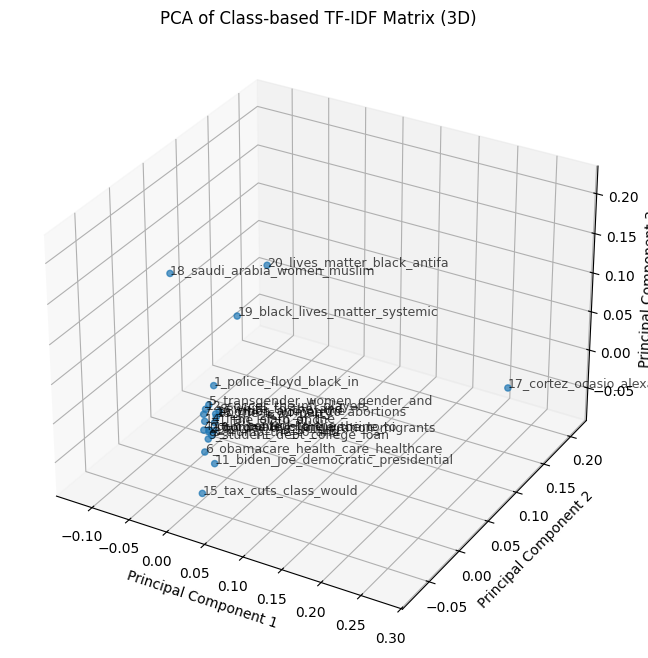

In [26]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Assuming `topic_model` is already fitted and `c_tf_idf` is the class-based TF-IDF matrix

# Perform PCA with 3 components
pca_3d = PCA(n_components=3)
c_tf_idf_pca_3d = pca_3d.fit_transform(c_tf_idf)  # Standardize if necessary

# Extract topic labels from the BERTopic model
topic_labels = {int(k): v for k, v in topic_model.get_topic_info().set_index("Topic").to_dict()["Name"].items()}

# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(c_tf_idf_pca_3d[:, 0], c_tf_idf_pca_3d[:, 1], c_tf_idf_pca_3d[:, 2], alpha=0.7)

# Annotate each point with its corresponding topic label
for i, topic_id in enumerate(topic_labels):
    # Extract the topic label
    topic_label = topic_labels[topic_id]
    
    # Annotate with the topic label at the corresponding PCA coordinates
    ax.text(c_tf_idf_pca_3d[i, 0], c_tf_idf_pca_3d[i, 1], c_tf_idf_pca_3d[i, 2], topic_label, fontsize=9, alpha=0.7)

# Set labels and title
ax.set_title("PCA of Class-based TF-IDF Matrix (3D)")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")

plt.show()


In [ ]:
import os
os.chdir("..")

In [48]:
from vendi_score import vendi
from sklearn.metrics.pairwise import cosine_similarity


pca_2d = PCA(n_components=2)
c_tf_idf_pca_2d = pca_2d.fit_transform(c_tf_idf) 

distance_matrix = cosine_similarity(c_tf_idf)
vendi.score_K(distance_matrix)



12.253374440608903

Term-frequency inverse document frequency (TF-IDF) matrix for each topic generated by the model.

TF-IDF is a statistical measure used to evaluate the importance of a word in a document relative to the entire corpus. 

c_tf_idf_ stands for the class-based TF-IDF that BERTopic uses for topic modeling. The c_ refers to class-based, meaning that the TF-IDF scores are computed for the topics, not just individual words in the documents.

In BERTopic, c_tf_idf_ is used to represent the importance of words in each topic. After fitting the model, BERTopic uses TF-IDF to assign relevance scores to each word within a topic based on how often it appears in documents assigned to that topic compared to the entire corpus.

Structure of c_tf_idf_:
* Shape: It’s a document-term matrix where:
* Rows represent topics (each topic is a "document").
* Columns represent terms (words) from the corpus.
* Content: The matrix contains the TF-IDF scores for words in each topic. Higher values mean that a word is more relevant to that specific topic

In [1]:
test = topic_model.c_tf_idf_[1::]
distance_matrix = cosine_similarity(test)
vendi.score_K(distance_matrix)

print(test)

NameError: name 'topic_model' is not defined

In [ ]:
import os
os.chdir("..")

In [114]:
from transformers import pipeline
from bertopic import BERTopic


# Extract the top words for each topic (already available)
top_words_per_topic = topic_model.get_topics()

# Extract representative documents for each topic
representative_docs = topic_model.get_representative_docs()

# Load a pre-trained LLM (e.g., T5 or GPT-3) for topic labeling
llm = pipeline('text-generation', model='openai-community/gpt2')  # Or use a summarization model

# Function to generate enhanced topic labels using both top words and representative documents
def generate_enhanced_topic_label(topic_id, top_words, representative_docs):
    # Join top words into a string
    top_words_str = ' '.join([word for word, _ in top_words])
    
    # Get the representative documents for the current topic
    rep_docs_str = ' '.join(representative_docs[topic_id][:3])  # Use top 3 representative docs (you can adjust this)
    
    # Combine the top words and representative documents into one string
    input_text = f"Topic description based on words: {top_words_str}. Documents: {rep_docs_str}"
    
    # Generate a coherent topic label/description using the LLM
    label = llm(input_text, max_length=300, truncation=True)[0]['generated_text']
    
    return label.strip()

# Generate labels for each topic using LLM
enhanced_labels = {}
for topic_id, top_words in top_words_per_topic.items():
    if topic_id == -1:  # Skip outlier topics
        continue
    # Generate an enhanced label using top words and representative documents
    topic_label = generate_enhanced_topic_label(topic_id, top_words, representative_docs)
    enhanced_labels[topic_id] = topic_label

# Update the topic labels with enhanced descriptions
topic_model.topic_labels_ = enhanced_labels

# Print enhanced labels for each topic
for topic_id, label in enhanced_labels.items():
    print(f"Topic {topic_id}: {label}")


Device set to use cpu
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:5

AttributeError: property 'topic_labels_' of 'BERTopic' object has no setter

In [116]:
enhanced_labels

{0: 'Topic description based on words: coronavirus the vaccine to of pandemic and in that covid. Documents: Millions of Americans are counting on a COVID-19 vaccine to curb the global pandemic and return life to normal. President Donald Trump asserted without evidence Friday that the COVID-19 pandemic will "go away without a vaccine." The comments contradict the belief of some of the president\'s task force members. Coronavirus vaccine and quarantine protesters in America form an unholy COVID-19 alliance. Here are just some of the reasons: A COVID-18 virus has not been found at every U.S. or foreign laboratory since its arrival in the U.S. in 1955, and is not considered an appropriate immunization in the U.S. The vaccine\'s first few months are marked by serious morbidity and mortality at highest incidence rates, though more recently several children and young patients have developed chronic illness as a consequence of exposure to this rare and virulent virus. The Centers for Disease C

In [84]:
topic_model = BERTopic.load("data/enriched/models/babe_model")
topic_model.get_topics()


c:\Users\sofik\Documents\Uni Konstanz\SEDS\Thesis\master-thesis\venv\Lib\site-packages\bertopic\_save_utils.py:187: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensors = t

{-1: [['the', 0.033062997994349544],
  ['of', 0.027735867228315586],
  ['to', 0.027632408343882885],
  ['and', 0.026613221422759396],
  ['in', 0.024216970479016373],
  ['on', 0.019302790650891664],
  ['that', 0.01890165874144856],
  ['trump', 0.01769893332711495],
  ['for', 0.017695539120021937],
  ['is', 0.014819773316392929]],
 0: [['coronavirus', 0.04653736948313105],
  ['the', 0.03877443203147158],
  ['vaccine', 0.032526849828536854],
  ['to', 0.029504862612483092],
  ['of', 0.02764122377277981],
  ['pandemic', 0.026597624838266404],
  ['and', 0.02430862391848266],
  ['in', 0.022561508151053723],
  ['that', 0.01975831295454996],
  ['covid', 0.01947030407172591]],
 1: [['police', 0.0685334038197833],
  ['floyd', 0.04649270222467523],
  ['black', 0.040037746251689266],
  ['in', 0.0397327630264202],
  ['george', 0.0347151000814029],
  ['the', 0.03374504503878317],
  ['of', 0.03360092086551542],
  ['death', 0.030894478378538686],
  ['man', 0.030663699870590994],
  ['protests', 0.028930